## Implementation of the Neural Network archtechture in a classificaiton problem

This shows one of the possible NN architecture. Other architectures can be used as well and loaded from the models.py file. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.models import *
from src.train import *
from src.data_loader import *

In [3]:
# Load the augmented data 
# x_train, y_train, x_predict = load_base_data() # In case you want to load the base data
x_train, y_train, x_predict = load_augmented_data()

# Round the target to the first decimal in order to create 10 categories
y_train_rounded_first_decimal = y_train.round(1)
cat_10 = spearmanr(y_train, y_train_rounded_first_decimal)[0]
print(f"Max possible score with 10 categories : {cat_10.round(2)}")
y_train = (y_train_rounded_first_decimal * 10).astype(int)

# Split the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train)

# Rescale the data and convert it to tensor
X_train, X_test, X_predict, Y_train, Y_test = rescale_data_convert_to_tensor(X_train, X_test, x_predict, Y_train, Y_test, classes=True)

# Augment the data by adding gaussian noise
X_train, X_test, Y_train, Y_test = augment_data(X_train, X_test, Y_train, Y_test)

# Apply PCA and reduce the number of features to 500
X_train, X_test, X_predict = apply_PCA(X_train, X_test, X_predict, n_components=500)
print(X_train.shape)

# Create the datasets and the dataloaders
train_dataset, train_loader, test_dataset, test_loader = get_datasets(X_train, Y_train, X_test, Y_test)

Max possible score with 10 categories : 0.95
(7744, 500)


<Axes: ylabel='Frequency'>

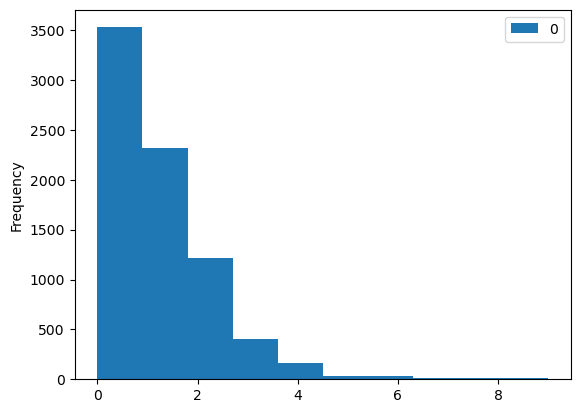

In [4]:
#Hisogram of the target distribution. We see that the data is not balanced and that no samples are available for some classes
pd.DataFrame(Y_train).plot.hist(bins=10)

In [5]:
# Set the hyperparameters for the encoder decoder training 
epochs = 10
number_classes = 11
device = "cuda" if torch.cuda.is_available() else "cpu"
neural_net = NeuralNetClasses(X_train.shape[1], number_classes).to(device)

neural_net.apply(init_weights)

optimizer = torch.optim.Adam(neural_net.parameters(), lr=1e-4, weight_decay=1e-4)


all_classes = range(number_classes)
class_counts = pd.Series(0, index=all_classes)  # Initialize all to zero
actual_counts = pd.Series(Y_train).value_counts().sort_index()  # Actual counts
print(actual_counts)

class_counts.update(actual_counts)  

class_weights = 1.0 / class_counts  # Compute inverse frequency
print(class_weights)
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

distance = nn.CrossEntropyLoss(weight=class_weights)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True, 
)
model_path = './models/neural_net_classes.pth'

count_parameters(neural_net)

0    3528
1    2320
2    1216
3     408
4     168
5      32
6      32
7      16
8       8
9      16
Name: count, dtype: int64
0     0.000283
1     0.000431
2     0.000822
3     0.002451
4     0.005952
5     0.031250
6     0.031250
7     0.062500
8     0.125000
9     0.062500
10         inf
dtype: float64
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| enc.0.weight |   192000   |
|  enc.0.bias  |    384     |
| enc.3.weight |   98304    |
|  enc.3.bias  |    256     |
| enc.6.weight |   16384    |
|  enc.6.bias  |     64     |
| enc.8.weight |    704     |
|  enc.8.bias  |     11     |
+--------------+------------+
Total Trainable Params: 308107


c:\Users\jerem\anaconda3\envs\ml\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


308107

In [6]:
#training loop
train_neural_net_classes(
    model = neural_net,
    distance=distance,
    optimizer = optimizer,
    scheduler = scheduler,
    train_loader = train_loader,
    test_loader = test_loader,
    Y_test = Y_test,
    model_path = model_path,
    epochs=epochs,
)

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

  0%|          | 0/968 [00:00<?, ?it/s]

In [7]:
# Evaluate the model locally and generate the submission file
neural_net = load_model(NeuralNetClasses(X_train.shape[1], number_classes), model_path)
spearmanr_neural_net(neural_net, X_test, Y_test, classes=True)
generate_submission_neural_net(X_predict, x_predict, neural_net, classes=True, path_to_file='./submissions/neural_net_classes.csv')

c:\Users\jerem\Documents\Informatique\MLCourse\ml-project-2-the_underfitters\src\models.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


Spearmann R coefficient for neural net is : 0.4820134852790133
Predicted 304 samples
